In [1]:
import backtrader as bt
import backtrader.feeds as btfeeds
import pyfolio as pf
import datetime
import pandas as pd
import numpy as np
import utils

In [2]:
# Strategy implementation
class StatArb(utils.RebalanceStrategy):
    params = dict(
        lookback_window = 60,  #how many days are used to calculate s-score
        enter_long_thresh = -1.25, #s-score threshold to generate a buy signal, in paper = -1.25
        enter_short_thresh = 1.25, #s-score threshold to generate a sell signal, in paper = 1.25
        exit_long_thresh = -0.5, #s-score threshold to generate an exit long signal, in paper = -0.5
        exit_short_thresh = 0.75, #s-score threshold to generate an exit short signal, in paper = 0.75
        cash_reserve = 0.01, # to ensure orders are executed, leave a % of the portfolio value available
        bet_size = 10000, # max daily exposure across the long/short positions 
        number_pca_components = 15, # number of pca factors to use, if less than 1: interpret as % variance explained
        choose_top = 1 - 0.1, # the percentile of funds chosen to be bought in every rebalance
        choose_bottom = 0.1 # the percentile of funds chosen to be sold.
    )
    
    def __init__(self, params):
        self.debug = True
        self.eigen = params[0]
        self.bal_dates = params[1]

    def rebalance(self):
        self.log("Recalculating factors")
        returns = self.calculate_returns()
        pca, eigen_portfolios, factor_returns = utils.calculate_pca_factors(returns, self.p.number_pca_components)
        self.eigen = eigen_portfolios
    
    def calculate_returns(self):
        prices = pd.DataFrame()
        returns = pd.DataFrame()
        for data in self.datas:
            current_size = len(data)
            if current_size >= self.p.lookback_window:
                prices[data._name] = data.get(size=self.p.lookback_window)
                returns[data._name] = prices[data._name].pct_change(1)
        return returns.dropna()
    
    def calculate_weights(self, scores):
        # Allocation strategy: allocate weights by s-score among all stocks over the thresholds
        # this strategy will have very high transaction costs due to daily rebalance
        
        thresh_top = scores.quantile(q=self.p.choose_top)
        thresh_bottom = scores.quantile(q=self.p.choose_bottom)
        top = scores[scores>thresh_top]
        bottom = scores[scores<thresh_bottom]
        
        weights = pd.Series(dtype='float64')
        shorts = pd.Series(dtype='float64')
        longs = pd.Series(dtype='float64')
        
        for data in self.datas:
            position = self.getposition(data).size
            if data._name in scores.index:
                score = scores[data._name]
                if data._name in top.index and score >= self.p.enter_short_thresh and position == 0:
                    if self.debug: self.log(f"enter short {data._name} | {score}")
                    weights[data._name] = -self.p.bet_size 
                elif data._name in bottom.index and score <= self.p.enter_long_thresh and position == 0:
                    if self.debug: self.log(f"enter long {data._name} | {score}")
                    weights[data._name] = self.p.bet_size
                elif position > 0 and score >= self.p.exit_long_thresh:
                    if self.debug: self.log(f"exit long {data._name} | {score}")
                    weights[data._name] = 0
                elif position < 0 and score <= self.p.exit_short_thresh:
                    if self.debug: self.log(f"exit short {data._name} | {score}")
                    weights[data._name] = 0
                   
        return weights                
        
    def next(self):
        curdate = self.datetime.date(ago=0)
        if curdate in self.bal_dates:
            self.rebalance()
        
        # show current status
        if self.debug: 
            self.log(f"Current portfolio value: {self.broker.get_value()}")    
        # Calculate residuals => s-scores => signals => execute orders
        returns = self.calculate_returns()
        if not returns.empty:
            valid_returns = self.eigen.columns.intersection(returns.columns)
            valid_eigen = self.eigen[valid_returns]
            returns = returns[valid_returns]
            factor_returns = pd.DataFrame(np.dot(returns, valid_eigen.transpose()), index = returns.index)
            residuals, betas = utils.calculate_residuals(returns, factor_returns, self.p.number_pca_components)
            # threshold for mean reversion speed is half a lookback period
            scores = utils.calculate_s_score(residuals, 252/(self.p.lookback_window/2)) 
            scores.sort_values(ascending=False)
            # Determine the new positions, execute the necessary orders
            # TODO: Mimic the PCA portfolio and hedge according to betas. unwind hedge at exit signal.
            weights = self.calculate_weights(scores)                
            self.execute_target_orders(weights*(1-self.p.cash_reserve))


In [3]:
# load tickers in the backtesting engine
def cerebro_load_prices(cerebro, universe):
    for ticker in universe:
        stock = data[data["TICKER"]==ticker]

        if not stock.empty:
            stock = stock[~stock.index.duplicated(keep='first')] # remove duplicate dates
            stock = stock.fillna(method='ffill')
            if not stock.isnull().values.any():
                cerebro.adddata(bt.feeds.PandasData(dataname=stock,
                                                    fromdate = start,
                                                    todate = end,
                                                    name = ticker,
                                                    open = 'OPENPRC',
                                                    high = 'ASKHI',
                                                    low  = 'BIDLO',
                                                    close = 'PRC',
                                                    volume = 'VOL',
                                                    openinterest=-1), name=ticker)

In [4]:
# Backtesting configuration and execution 

#parameters
mktcap_thresh = 10000 # in millions



Wall time: 53.8 s
2018-01-02, Current portfolio value: 1000000.0
2018-01-03, Current portfolio value: 1000000.0
2018-01-04, Current portfolio value: 1000000.0
2018-01-05, Current portfolio value: 1000000.0
2018-01-08, Current portfolio value: 1000000.0
2018-01-09, Current portfolio value: 1000000.0
2018-01-10, Current portfolio value: 1000000.0
2018-01-11, Current portfolio value: 1000000.0
2018-01-12, Current portfolio value: 1000000.0
2018-01-16, Current portfolio value: 1000000.0
2018-01-17, Current portfolio value: 1000000.0
2018-01-18, Current portfolio value: 1000000.0
2018-01-19, Current portfolio value: 1000000.0
2018-01-22, Current portfolio value: 1000000.0
2018-01-23, Current portfolio value: 1000000.0
2018-01-24, Current portfolio value: 1000000.0
2018-01-25, Current portfolio value: 1000000.0
2018-01-26, Current portfolio value: 1000000.0
2018-01-29, Current portfolio value: 1000000.0
2018-01-30, Current portfolio value: 1000000.0
2018-01-31, Current portfolio value: 10000

2018-03-29, enter long CAT | -1.7894317187324251
2018-03-29, exit long CHD | -0.2432092284870574
2018-03-29, enter short DIS | 1.8148390584563105
2018-03-29, enter long D | -1.5644095659263877
2018-03-29, enter long OMC | -1.4223021760991448
2018-03-29, exit short MCD | 0.33724258074131824
2018-03-29, enter long MCK | -1.3202651179888145
2018-03-29, enter short XEL | 1.6242881452946623
2018-03-29, enter short NOC | 1.6115672514168347
2018-03-29, enter short PG | 1.886783858359117
2018-03-29, enter short LUV | 1.5080800050960403
2018-03-29, enter long TMO | -1.5890108927005409
2018-03-29, enter short CNQ | 1.571289061053817
2018-03-29, enter long ESRX | -1.4629031420812635
2018-03-29, enter short BAP | 1.5676587828588233
2018-03-29, enter long DVA | -1.2615508110361946
2018-03-29, enter long AMZN | -1.3922226135399454
2018-03-29, exit long MMP | -0.38221173069333675
2018-03-29, enter short CVE | 1.5553917019811867
2018-04-02, CHD Order 74 Status Completed:| Size:-201 | Price:$50.32
2018

2018-04-05, exit long GIS | -0.4387656587113706
2018-04-05, exit short INTC | 0.6225576612872217
2018-04-05, enter long JCI | -1.2744109108832757
2018-04-05, enter short KEY | 1.5939122046759893
2018-04-05, exit long TECK | -0.48991975121148146
2018-04-05, exit long TMO | -0.24704277998054922
2018-04-05, enter short CERN | 1.6386714123058321
2018-04-05, exit short REGN | -0.19283024586606967
2018-04-05, enter long IDXX | -1.4039618529698223
2018-04-05, enter short BSX | 2.9513176647736388
2018-04-05, exit short COST | 0.24472441371520026
2018-04-05, exit short BMRN | 0.6579896289612949
2018-04-05, enter short EXPE | 1.504978302104164
2018-04-05, enter short EW | 1.646264905051071
2018-04-05, enter long NFLX | -1.3947876957439853
2018-04-05, enter short CRM | 1.722989031189942
2018-04-05, enter short ICE | 1.5162685204859554
2018-04-05, exit long FB | -0.4425206058842694
2018-04-05, exit short MPC | 0.7014858905222678
2018-04-06, GIS Order 163 Status Completed:| Size:-223 | Price:$45.5


2018-04-11, enter short ADP | 1.6461530411669392
2018-04-11, enter long BMY | -1.5991774049021257
2018-04-11, enter long STZ | -1.3737903773757112
2018-04-11, exit long CAH | -0.454937970611745
2018-04-11, exit long CAT | -0.40575433581499465
2018-04-11, enter short CMA | 1.70039327219579
2018-04-11, enter long GWW | -1.6788246570783303
2018-04-11, exit long HLT | 0.6589752129802315
2018-04-11, exit long JCI | -0.34479260195516714
2018-04-11, enter short MRK | 2.5956769470227057
2018-04-11, enter short NEM | 2.4006725548241814
2018-04-11, enter long PPG | -1.3301705191515156
2018-04-11, exit long PAYX | 0.5648302208158514
2018-04-11, exit short ROST | 0.4195206497311825
2018-04-11, enter short TXN | 1.9757600036001017
2018-04-11, enter long MS | -1.3788457448508498
2018-04-11, exit long ORCL | -0.49373491942746606
2018-04-11, exit long PYPL | -0.3060145121112426
2018-04-11, exit short DHI | 0.5910984154748454
2018-04-11, enter long ORLY | -1.414044753765887
2018-04-11, enter short WRK 

2018-04-17, enter long HES | -1.4007066231474394
2018-04-17, enter long CPB | -1.2829167133356236
2018-04-17, exit short CVX | 0.7188644916016905
2018-04-17, exit short CMA | -0.9235907237154181
2018-04-17, exit long OMC | -0.39645280723274984
2018-04-17, enter long ETN | -1.4538530926188646
2018-04-17, enter long NEE | -1.5914514177870134
2018-04-17, enter long MTB | -1.791432032340798
2018-04-17, enter short KMI | 2.5894845530643753
2018-04-17, exit long LB | -0.3348047933581136
2018-04-17, enter long MKC | -1.4005420674534947
2018-04-17, enter short OXY | 1.6870854433597833
2018-04-17, exit long FE | 0.19284520299853924
2018-04-17, exit short ROK | 0.7399927400975628
2018-04-17, enter long SJM | -1.4951224659037503
2018-04-17, exit long MPLX | -0.02555494076530306
2018-04-17, exit short UNM | 0.6467223148215416
2018-04-17, enter short MGM | 1.9563945527114288
2018-04-17, enter short WDAY | 2.16778102135985
2018-04-17, exit short CNQ | 0.7047830131460369
2018-04-17, enter short PYPL 

2018-04-20, exit long HES | -0.26513868828284304
2018-04-20, exit short ADSK | 0.6108534786204242
2018-04-20, enter short BDX | 1.4006525073632594
2018-04-20, exit long STZ | 0.5713314624444813
2018-04-20, enter long CHD | -2.5958975916522693
2018-04-20, exit short CL | 0.14244336968776652
2018-04-20, enter long TAP | -1.7855356673195846
2018-04-20, exit short DHR | 0.7148346437580946
2018-04-20, exit short TGT | 0.4324952813684964
2018-04-20, exit short FDX | -0.05164956156977495
2018-04-20, enter short GE | 1.381915875490246
2018-04-20, enter short HAL | 1.3664007808838112
2018-04-20, enter short HD | 1.4019689697788735
2018-04-20, exit short HRL | 0.47997074297540854
2018-04-20, enter long INTC | -2.2437365427935467
2018-04-20, enter long LB | -1.867243712772779
2018-04-20, enter long MAS | -1.8474590900717986
2018-04-20, exit short NWL | -0.5311428577011287
2018-04-20, exit short NEM | -0.25224166760397326
2018-04-20, enter short ES | 1.798139819509308
2018-04-20, exit short NTRS |

2018-04-24, enter long AMAT | -1.6217117383015924
2018-04-24, enter short BAX | 1.6772932430609064
2018-04-24, exit long BCE | 0.3042249045421612
2018-04-24, enter long CAT | -2.1740185824833844
2018-04-24, exit short KO | 0.14280490858342285
2018-04-24, enter short ED | 1.4406587107343503
2018-04-24, exit short CMI | 0.09581788595995253
2018-04-24, enter long EQT | -1.6899508484816068
2018-04-24, enter short FITB | 1.5138440117957812
2018-04-24, exit long MTB | -0.49845722792364483
2018-04-24, enter short HLT | 1.9096969038785372
2018-04-24, exit long INTC | 0.2590780491695557
2018-04-24, enter long PCAR | -1.5276943786980415
2018-04-24, exit short UAL | 0.532798131720177
2018-04-24, enter short AEE | 2.0050406209328946
2018-04-24, exit long WHR | 0.15354233535686101
2018-04-24, exit long WMB | 0.13399532818814675
2018-04-24, enter long FISV | -1.4129930664551755
2018-04-24, enter long PGR | -1.5184243542411633
2018-04-24, enter short MGM | 1.5197107545636817
2018-04-24, enter long FC

2018-04-30, enter short DIS | 1.9173898894246233
2018-04-30, exit short HLT | 0.5349672283806227
2018-04-30, enter short MCD | 1.89289502669747
2018-04-30, enter short MDT | 1.855456069398648
2018-04-30, exit long MSI | 0.09203366911213158
2018-04-30, enter short BAC | 1.6906312316551357
2018-04-30, enter short NWL | 1.7353481414425098
2018-04-30, enter short NKE | 1.8801719864192847
2018-04-30, exit long MO | -0.43923340273155953
2018-04-30, exit long TECK | -0.2823725817923921
2018-04-30, enter short VFC | 1.8293963840783756
2018-04-30, enter short VMC | 1.9768660594770748
2018-04-30, enter long ZTS | -1.6991128136262295
2018-04-30, exit short DB | 0.5909552538878297
2018-04-30, exit short TMUS | 0.13575460360937947
2018-04-30, exit short HUM | 0.7383154988820134
2018-04-30, exit long SIRI | -0.20523781081001022
2018-04-30, enter short JNPR | 1.8600237029111995
2018-04-30, enter short CNHI | 1.7810399366230951
2018-05-01, DIS Order 584 Status Completed:| Size:-98 | Price:$100.18
2018

2018-05-04, exit short AET | 0.08221919466736342
2018-05-04, enter long APD | -1.3725334357776053
2018-05-04, exit short BDX | 0.25468740698461695
2018-05-04, exit short CMS | 0.7193194937888044
2018-05-04, exit long ETN | -0.3701715485619204
2018-05-04, exit short ECL | 0.5072545360246682
2018-05-04, exit short FITB | 0.7195191683899225
2018-05-04, enter long GD | -1.3713083830965773
2018-05-04, enter short KHC | 3.0988020928781825
2018-05-04, exit long KLAC | -0.49732529418414956
2018-05-04, exit long K | 0.46631032890120316
2018-05-04, exit short CVS | 0.47755780753190624
2018-05-04, enter long MSI | -1.962094427670766
2018-05-04, exit short NKE | 0.6860223302859093
2018-05-04, enter long NBL | -1.785049425088506
2018-05-04, enter long PFE | -2.566665312035064
2018-05-04, enter short EXC | 2.257308224489615
2018-05-04, enter long T | -1.7976192711548924
2018-05-04, exit short SYY | 0.33261960638839394
2018-05-04, enter long TECK | -1.436873862540619
2018-05-04, exit short VFC | 0.48

2018-05-08, exit short CMCSA | 0.39109032909097247
2018-05-08, enter short C | 1.62884926067782
2018-05-08, enter long DTE | -1.9416250138619149
2018-05-08, exit long EQT | -0.17147413079218377
2018-05-08, enter long TMUS | -1.6115363493698587
2018-05-08, exit short IDXX | 0.023673889645180433
2018-05-08, exit long ROP | -0.3061539977790262
2018-05-08, exit short BSX | 0.7151007381978047
2018-05-08, enter long ICE | -1.8511293364061836
2018-05-08, exit long AVGO | 0.04609346334369816
2018-05-09, C Order 757 Status Completed:| Size:-139 | Price:$71.23
2018-05-09, EQT Order 758 Status Completed:| Size:-403 | Price:$51.2
2018-05-09, ROP Order 759 Status Completed:| Size:-37 | Price:$273.01001
2018-05-09, AVGO Order 760 Status Completed:| Size:-42 | Price:$235.8
2018-05-09, CMCSA Order 761 Status Completed:| Size:305 | Price:$30.57
2018-05-09, DTE Order 762 Status Completed:| Size:97 | Price:$101.14
2018-05-09, TMUS Order 763 Status Completed:| Size:178 | Price:$55.89999999999999
2018-05-0

2018-05-11, exit long AMGN | -0.48754653291090566
2018-05-11, enter long CHD | -1.6686475210486393
2018-05-11, exit long DTE | -0.3662016108462643
2018-05-11, enter short HLT | 1.3782062591403648
2018-05-11, enter short MRK | 1.3406765897019706
2018-05-11, enter long ETR | -1.5595558662664208
2018-05-11, enter long NLSN | -1.66219523480474
2018-05-11, enter long CE | -1.6711494239886924
2018-05-11, enter long PANW | -1.585695389426186
2018-05-11, exit short ULTA | 0.6810283412739339
2018-05-11, enter long FLT | -1.6026073608746239
2018-05-14, AMGN Order 834 Status Completed:| Size:-58 | Price:$174.10001
2018-05-14, DTE Order 835 Status Completed:| Size:-97 | Price:$102.53
2018-05-14, HLT Order 836 Status Completed:| Size:-118 | Price:$83.49
2018-05-14, MRK Order 837 Status Completed:| Size:-165 | Price:$59.77
2018-05-14, CHD Order 838 Status Completed:| Size:208 | Price:$47.3
2018-05-14, ETR Order 839 Status Completed:| Size:125 | Price:$79.06
2018-05-14, NLSN Order 840 Status Complete

2018-05-17, enter short SWKS | 1.511556551403158
2018-05-17, exit short AEP | -0.3580398612314853
2018-05-17, exit short MRK | 0.6276160155246315
2018-05-17, exit long MYL | -0.1765564935074232
2018-05-17, enter long MO | -1.4372484115419863
2018-05-17, enter short AEE | 1.5828309999959347
2018-05-17, exit long WDC | -0.34650401705207196
2018-05-17, enter short WHR | 1.5661630312893509
2018-05-17, exit long ZTS | -0.4582917361958577
2018-05-17, exit long FCX | -0.47216645049821965
2018-05-17, exit short LH | 0.4656520359740732
2018-05-17, enter short EOG | 1.9860509271394176
2018-05-17, enter short LSXMK | 1.4203794327982766
2018-05-17, exit long YUMC | 0.019659660477544763
2018-05-17, exit short EPD | 0.5389433706239818
2018-05-17, enter short SBAC | 1.6547770996620783
2018-05-17, exit short BMRN | 0.6277762840268863
2018-05-17, exit short MMP | 0.6241071868938282
2018-05-17, exit long CE | -0.38136620055487674
2018-05-18, SWKS Order 919 Status Completed:| Size:-99 | Price:$98.31
2018

2018-05-22, enter long APA | -1.4157271714440467
2018-05-22, enter long ADSK | -1.6905610523241614
2018-05-22, enter short BCE | 2.509271925522855
2018-05-22, exit long AON | 0.416580948385784
2018-05-22, exit long TAP | -0.1985493685050109
2018-05-22, exit long HPQ | -0.177596931505911
2018-05-22, exit short HLT | 0.20917401985435824
2018-05-22, exit long INTC | -0.11480385668111545
2018-05-22, exit short ENB | 0.3325910924501022
2018-05-22, exit long MMC | -0.07127434550036398
2018-05-22, exit long ETR | -0.16317233519736474
2018-05-22, exit long PCAR | -0.4944805376724094
2018-05-22, exit long SRE | -0.30457022894909364
2018-05-22, enter long PH | -2.048848128434676
2018-05-22, enter long PNR | -1.2756532653241195
2018-05-22, enter long SHW | -2.337693911182357
2018-05-22, exit long SJM | -0.4813049877970277
2018-05-22, exit long TJX | -0.2297115234806891
2018-05-22, exit short FISV | 0.7167034458286373
2018-05-22, exit long UNM | -0.38289915252835743
2018-05-22, exit long PGR | 0.2

2018-05-25, exit long AEP | -0.4978815475576427
2018-05-25, enter short CAT | 1.543140734405887
2018-05-25, enter short CLX | 1.5607848705077714
2018-05-25, exit long CL | -0.40721811855809453
2018-05-25, enter long CLR | -1.3166505592883908
2018-05-25, exit long CMI | -0.49800975232893585
2018-05-25, enter short DE | 1.4280142415211923
2018-05-25, enter short D | 1.324773769930569
2018-05-25, enter short XOM | 1.3778449081354902
2018-05-25, enter short FDX | 1.5317657173074126
2018-05-25, enter long FITB | -1.5831892592224803
2018-05-25, enter long HRL | -1.385514409464871
2018-05-25, exit short LOW | 0.3256469206611526
2018-05-25, enter short MRO | 1.3636829907347894
2018-05-25, enter short ETR | 1.7177682085072565
2018-05-25, exit short NKE | -0.2102031535177183
2018-05-25, enter short OKE | 1.4882031474992796
2018-05-25, exit long PPG | -0.25839477640793906
2018-05-25, exit long PCG | -0.09461419031412507
2018-05-25, exit long T | -0.4210600748333963
2018-05-25, exit short STT | 0.

2018-05-31, exit long ADSK | -0.03084960262115073
2018-05-31, exit short BAX | 0.4624279767876253
2018-05-31, exit long CVX | -0.09368607638111591
2018-05-31, enter short CHD | 1.6588778016499637
2018-05-31, enter short CA | 1.7457989491898902
2018-05-31, exit long GLW | 0.1840375537104103
2018-05-31, enter long DG | -2.156237694543745
2018-05-31, enter short EQT | 1.653255159936242
2018-05-31, enter short HPQ | 1.6339419084209519
2018-05-31, enter short HBAN | 1.6921353352832351
2018-05-31, exit short KMB | 0.5275485351421306
2018-05-31, enter short MMC | 2.0381524772816415
2018-05-31, enter long BAC | -1.355552813418449
2018-05-31, exit short RCI | 0.5092722016609086
2018-05-31, exit long LUV | -0.3777757549290132
2018-05-31, enter long CSCO | -1.2890577366528075
2018-05-31, exit short LBRDK | 0.5497031968975132
2018-05-31, exit long CFG | -0.16480559936546002
2018-05-31, enter short INTU | 1.5284486212473127
2018-05-31, enter long DLTR | -2.73684351496173
2018-05-31, enter long HSIC

2018-06-05, exit long HES | -0.47617573084441944
2018-06-05, exit long APA | -0.3382300970419765
2018-06-05, exit long ADM | -0.16317160435478412
2018-06-05, enter short GOLD | 1.730957316869242
2018-06-05, enter short CTAS | 1.8134635192454087
2018-06-05, enter short GPC | 1.7102593819958396
2018-06-05, enter long PH | -1.3344412707423607
2018-06-05, enter short PFE | 1.759331300818702
2018-06-05, exit long TMO | -0.2267623469546166
2018-06-05, enter short WY | 1.6936203358399242
2018-06-05, enter short APH | 2.2176654575618944
2018-06-05, exit short SYF | 0.19000403263292776
2018-06-05, exit long HPE | -0.35770547272894454
2018-06-05, enter long RCL | -1.5790886888717497
2018-06-05, exit long EMN | -0.3119648559994875
2018-06-05, exit long ABC | -0.4445301724548923
2018-06-05, exit long TSLA | -0.23494281296647765
2018-06-05, enter short LYB | 1.698084607294336
2018-06-06, HES Order 1227 Status Completed:| Size:-169 | Price:$61.11
2018-06-06, APA Order 1228 Status Completed:| Size:-2

2018-06-12, enter long CAG | -1.4552829668610883
2018-06-12, enter long CMI | -1.3751890326623666
2018-06-12, exit long ITW | -0.051722819046161016
2018-06-12, exit short MMC | 0.4049504061671435
2018-06-12, exit long PH | -0.3646981582212714
2018-06-12, enter long RTN | -1.5241203551692204
2018-06-12, exit short AEE | 0.4447354232594602
2018-06-12, exit short LSXMK | 0.6209834554580669
2018-06-12, exit short GIB | 0.600564846807766
2018-06-12, enter short HCA | 1.4128104884256574
2018-06-12, enter short MNST | 1.411756589178498
2018-06-12, enter short WAT | 1.983008485430615
2018-06-12, exit long XEC | -0.1416185009786319
2018-06-13, ITW Order 1306 Status Completed:| Size:-67 | Price:$149.71001
2018-06-13, PH Order 1307 Status Completed:| Size:-57 | Price:$173.96001
2018-06-13, HCA Order 1308 Status Completed:| Size:-93 | Price:$106.87
2018-06-13, MNST Order 1309 Status Completed:| Size:-176 | Price:$56.43
2018-06-13, WAT Order 1310 Status Completed:| Size:-47 | Price:$209.03999000000

2018-06-19, enter short AME | 1.77666117767266
2018-06-19, enter short ADP | 1.7501987746289402
2018-06-19, enter short BAX | 1.7090798537678211
2018-06-19, exit long CMA | 0.2070602944007202
2018-06-19, exit short TAP | 0.4730581654181824
2018-06-19, enter short EFX | 1.832410228105139
2018-06-19, exit long MTB | -0.34224068681387143
2018-06-19, exit short LLY | 0.5137051325669758
2018-06-19, exit short MCD | 0.6418523642093181
2018-06-19, exit short UPS | 0.1620286836185741
2018-06-19, exit short WMT | 0.23894432191637638
2018-06-19, enter long FCAU | -1.3801658556897565
2018-06-19, enter short FTV | 1.7110349920345798
2018-06-19, enter short AGN | 1.7619550118347838
2018-06-19, exit short FB | 0.5120969634206591
2018-06-19, enter long VRSK | -1.2825846401703676
2018-06-20, AME Order 1374 Status Completed:| Size:-134 | Price:$73.88
2018-06-20, ADP Order 1375 Status Completed:| Size:-71 | Price:$138.63
2018-06-20, BAX Order 1376 Status Completed:| Size:-133 | Price:$74.12
2018-06-20, 

2018-06-25, enter short TAP | 1.964855271819017
2018-06-25, exit long CMI | -0.3990742754237956
2018-06-25, enter short DE | 1.7917335980529712
2018-06-25, enter short KHC | 1.948158272671188
2018-06-25, enter short CNP | 1.7672597961033134
2018-06-25, enter long MRK | -1.424882884743353
2018-06-25, exit long PNR | -0.20431311067823135
2018-06-25, enter long RCI | -1.3512466897385926
2018-06-25, enter long WY | -1.2670143804852771
2018-06-25, enter long SU | -2.083755234513196
2018-06-25, exit short AMZN | -0.06254823355155942
2018-06-25, enter long ULTA | -1.4099723994862334
2018-06-25, exit long CVE | -0.37184409954014763
2018-06-26, TAP Order 1470 Status Completed:| Size:-141 | Price:$69.47
2018-06-26, CMI Order 1471 Status Completed:| Size:-68 | Price:$134.77
2018-06-26, DE Order 1472 Status Completed:| Size:-70 | Price:$140.03
2018-06-26, KHC Order 1473 Status Completed:| Size:-156 | Price:$63.58
2018-06-26, CNP Order 1474 Status Completed:| Size:-364 | Price:$27.109999999999996
2

2018-06-28, exit long APD | -0.23674364932299366
2018-06-28, enter long BK | -1.2826799666956354
2018-06-28, enter short ED | 2.6545486654746164
2018-06-28, exit short GLW | 0.7285806085609138
2018-06-28, enter short EQT | 1.8868913473961857
2018-06-28, enter long JBHT | -1.584621204933188
2018-06-28, enter short IBM | 1.5948540141116503
2018-06-28, enter long CVS | -1.3498062640989756
2018-06-28, enter short MO | 1.908600215701012
2018-06-28, exit long TMO | 0.03681388504144975
2018-06-28, enter long WBA | -1.9117018235846515
2018-06-28, exit long WY | -0.32024028853846276
2018-06-28, enter short WEC | 1.7682807119900203
2018-06-28, enter long CCL | -1.3867755556392236
2018-06-28, enter long SJR | -1.468408307760937
2018-06-28, exit long SU | -0.01202827569407647
2018-06-28, enter short COG | 1.6518138031263627
2018-06-28, enter short GILD | 2.1693039599133592
2018-06-28, exit long DHI | -0.28591379221704205
2018-06-28, enter long MAR | -1.6031812813749244
2018-06-28, enter short NOV 

2018-07-02, enter short ADSK | 1.501220252473764
2018-07-02, enter short BMY | 1.9717084681142092
2018-07-02, exit long CNI | -0.44800186275146775
2018-07-02, exit short ED | 0.6172287359457155
2018-07-02, enter long DHR | -1.254199657827793
2018-07-02, exit short EQT | 0.689457274253602
2018-07-02, exit short MMC | 0.3996708247578014
2018-07-02, exit long PCG | -0.10061590234136358
2018-07-02, exit long PH | -0.4280329573906447
2018-07-02, enter short STI | 1.4269991097945236
2018-07-02, enter long WMT | -1.3328919216253812
2018-07-02, exit short WEC | 0.5614921204845256
2018-07-02, exit short ADBE | 0.5923209114470268
2018-07-02, enter short SU | 1.4470465611161265
2018-07-02, exit long FCAU | -0.2706439602426642
2018-07-02, exit long DB | -0.4521317641799064
2018-07-02, enter long ESRX | -1.3563458490568692
2018-07-02, enter short GS | 1.462173504374117
2018-07-02, exit long PBA | -0.24189303134912968
2018-07-02, enter short CRM | 1.4383936374288466
2018-07-02, enter short DPS | 1.3

2018-07-09, enter long APD | -1.4468792350358908
2018-07-09, enter short AMGN | 2.0387965873886915
2018-07-09, exit short BCE | 0.5711981878418906
2018-07-09, exit short TU | 0.6402706351356765
2018-07-09, exit long CAT | -0.31451390647111704
2018-07-09, enter long CMCSA | -1.2914153099520393
2018-07-09, exit short TAP | 0.24226605489528275
2018-07-09, exit short HBAN | 0.29803022005212687
2018-07-09, exit short K | 0.6127098520087485
2018-07-09, exit long LRCX | -0.14451788052384018
2018-07-09, enter short NEM | 1.7559557699264692
2018-07-09, exit short WFC | -0.056661513215397856
2018-07-09, enter short RTN | 1.6760677683455418
2018-07-09, exit short ROST | 0.17911449164029491
2018-07-09, enter short LUV | 1.9704038982971266
2018-07-09, enter long TXN | -1.776525570677461
2018-07-09, enter long TSN | -1.2950172122101773
2018-07-09, exit long FRC | -0.0919189351502641
2018-07-09, exit short SU | -0.19211058475528134
2018-07-09, exit short BMO | 0.4541529034370102
2018-07-09, exit shor

2018-07-12, enter short AEP | 1.985789354002611
2018-07-12, exit short KO | 0.6480250345728512
2018-07-12, exit long DAL | -0.43131542204341317
2018-07-12, exit long FITB | -0.44124878732115397
2018-07-12, enter short GD | 1.8342657417995614
2018-07-12, enter long JBHT | -1.2890960047914106
2018-07-12, exit long INTC | -0.31631073406438104
2018-07-12, exit short LB | -0.285102551203428
2018-07-12, exit short NEM | 0.17150160150685204
2018-07-12, exit long NSC | -0.3033408079550122
2018-07-12, enter long KEY | -1.7152988534422122
2018-07-12, exit long TXN | 0.3172380097104437
2018-07-12, exit long TXT | 0.25308940301095784
2018-07-12, enter short TRP | 1.6528295467937322
2018-07-12, enter short MSFT | 1.5521271437882052
2018-07-12, enter short BMO | 1.6115177641376228
2018-07-12, enter long ABBV | -1.2668840498274159
2018-07-12, exit short PRGO | 0.31373928638715604
2018-07-12, enter long BSX | -1.5509056262656176
2018-07-12, exit long ESRX | -0.18368570835868192
2018-07-12, enter long 

2018-07-17, exit long AAL | -0.4191728929777747
2018-07-17, exit short APA | 0.3744604029107605
2018-07-17, enter short BLL | 1.515383971174235
2018-07-17, exit long CSX | -0.4599790547971251
2018-07-17, enter short KO | 1.7276570951355488
2018-07-17, enter short CMI | 1.522198611571277
2018-07-17, enter long OMC | -1.8770703936258621
2018-07-17, enter short ECL | 1.7024220989971848
2018-07-17, enter short GE | 1.4822368934390844
2018-07-17, exit short CNP | -0.2526917969347069
2018-07-17, exit short ENB | 0.4363415762661182
2018-07-17, exit long MRK | 0.15536860339048494
2018-07-17, enter short PPG | 1.6638809241965151
2018-07-17, enter short PCAR | 1.9196504470422269
2018-07-17, exit short PNR | 0.7380877922676278
2018-07-17, exit long TMO | -0.37378652953949465
2018-07-17, exit short TRP | 0.37441915093853406
2018-07-17, exit long PXD | 0.1978673900727368
2018-07-17, enter short MGM | 2.1638521312437673
2018-07-17, exit short FCX | 0.44075652795421544
2018-07-17, enter short RY | 1.

2018-07-20, enter short HON | 2.928492866384316
2018-07-20, enter long SWKS | -1.5677381968144304
2018-07-20, exit short AME | 0.5467355260114926
2018-07-20, exit short ADM | 0.5455154606018365
2018-07-20, enter long VZ | -1.3476097371410594
2018-07-20, enter short CSX | 1.5616118634325915
2018-07-20, exit short ETN | 0.5621768621326002
2018-07-20, exit short GE | 0.3077044312190094
2018-07-20, enter short GPC | 1.7820526670406913
2018-07-20, exit long HD | -0.01306917351166653
2018-07-20, enter long LOW | -1.253439472234845
2018-07-20, enter short NSC | 1.673130559933554
2018-07-20, enter short NUE | 1.5313797609291466
2018-07-20, enter long OKE | -1.5706855891745022
2018-07-20, exit short PCAR | 0.532056444514249
2018-07-20, exit short RTN | 0.5616600921769132
2018-07-20, enter long T | -1.2983023623014154
2018-07-20, enter short SWK | 2.0240949678207705
2018-07-20, enter short UAL | 1.9094906265427423
2018-07-20, exit long UPS | -0.3695359306108345
2018-07-20, exit short UHS | -0.06

2018-07-24, exit long BAX | -0.2372253335265351
2018-07-24, enter short BMY | 1.78514807052757
2018-07-24, exit long CAG | -0.27202882368642023
2018-07-24, enter short JNJ | 1.4147330742576916
2018-07-24, exit long LLY | -0.06507535079323058
2018-07-24, enter short MAS | 1.462368435803056
2018-07-24, enter long MU | -1.3793199590624343
2018-07-24, enter long FE | -1.2655369066144897
2018-07-24, enter short MO | 1.4214062923779107
2018-07-24, exit short S | 0.2866655633535741
2018-07-24, exit short MXIM | 0.39557234497310934
2018-07-24, exit short VRTX | 0.6583562375834787
2018-07-24, enter short TWX | 1.6090626289507193
2018-07-24, exit long FDC | 0.3795349968597528
2018-07-24, enter long AGR | -1.6232435908719722
2018-07-24, enter short HSIC | 1.4807360292633889
2018-07-24, enter short SCCO | 1.6323013616810949
2018-07-24, enter long NOV | -1.4643572814668255
2018-07-24, enter long DGX | -1.2546353962324144
2018-07-24, enter short MA | 1.9106620162773564
2018-07-24, enter long NXPI | 

2018-07-27, enter long BAX | -1.4844139409507628
2018-07-27, exit short BMY | 0.47162206654898176
2018-07-27, enter short MSI | 1.6504750691421302
2018-07-27, exit short NSC | 0.6219125863489432
2018-07-27, enter short XRAY | 1.744846693714536
2018-07-27, enter short EOG | 1.9136658728419578
2018-07-27, enter long EA | -1.5121612056542182
2018-07-27, exit long YUMC | -0.4021924437637901
2018-07-27, exit long NOV | 0.048960480228095016
2018-07-27, enter long FB | -2.018890427675914
2018-07-27, enter long VRSK | -1.5301862063412768
2018-07-27, enter long LYB | -1.4920784178157593
2018-07-30, MSI Order 2115 Status Completed:| Size:-80 | Price:$122.94000000000001
2018-07-30, XRAY Order 2116 Status Completed:| Size:-209 | Price:$46.7
2018-07-30, EOG Order 2117 Status Completed:| Size:-76 | Price:$130.45
2018-07-30, YUMC Order 2118 Status Completed:| Size:-265 | Price:$37.07
2018-07-30, NOV Order 2119 Status Completed:| Size:-234 | Price:$47.41
2018-07-30, BAX Order 2120 Status Completed:| S

2018-08-02, enter long AAL | -2.1247525940481022
2018-08-02, exit short AMAT | 0.7165192910598066
2018-08-02, exit short BDX | -0.12973484780614036
2018-08-02, exit short CP | 0.5600611394911126
2018-08-02, exit long DE | -0.027687121814369876
2018-08-02, exit short DIS | 0.46016107522205946
2018-08-02, exit short DUK | 0.6037925707295447
2018-08-02, enter short FITB | 1.371026970837881
2018-08-02, enter long GM | -1.8848652633231955
2018-08-02, enter short KMB | 1.3989967058458992
2018-08-02, enter short LLY | 1.5676402573046913
2018-08-02, exit short MAS | 0.5615344853081977
2018-08-02, exit short LUV | 0.4855200319173646
2018-08-02, exit short SWK | 0.37842795172262916
2018-08-02, enter long AEE | -2.2420870448521377
2018-08-02, exit short UHS | 0.719438710727488
2018-08-02, exit short WMT | -0.4641934081553347
2018-08-02, exit short WEC | -0.5554043341913598
2018-08-02, exit short APH | 0.5280829224291815
2018-08-02, enter short PXD | 1.3209246904960683
2018-08-02, enter long SU | 

2018-08-07, enter short CI | 1.3509676765782221
2018-08-07, enter long KO | -2.008396825617335
2018-08-07, enter long CL | -2.5752421538028654
2018-08-07, exit short GLW | 0.6062904827496746
2018-08-07, exit short FITB | 0.6285451799130509
2018-08-07, enter long USB | -1.8508626222515607
2018-08-07, enter long NUE | -1.8411061860707287
2018-08-07, enter long PEP | -1.8736698538574303
2018-08-07, enter long TXT | -2.049371485528525
2018-08-07, exit short TRP | 0.526986882462996
2018-08-07, exit short PXD | 0.4682592654054507
2018-08-07, exit short FTS | 0.6456107191901075
2018-08-07, enter long GIB | -1.9992216401412493
2018-08-07, enter short DLTR | 1.3644232932241354
2018-08-07, exit short CHKP | 0.5928420270039686
2018-08-07, enter long EXPE | -1.8228741698923878
2018-08-07, exit long XEC | -0.48523382958025874
2018-08-07, exit short PSX | 0.6076024623188798
2018-08-07, exit long DFS | -0.18862142217819608
2018-08-08, CI Order 2271 Status Completed:| Size:-52 | Price:$188.67000000000

2018-08-13, enter short APD | 2.5403035545170636
2018-08-13, exit short AMAT | 0.5747307349941936
2018-08-13, enter short ADSK | 1.9665654960720842
2018-08-13, enter short TU | 1.3311572364637945
2018-08-13, enter short ECL | 1.5507379459141077
2018-08-13, enter long KMI | -1.6275148442542908
2018-08-13, exit long MCK | -0.3667261137286877
2018-08-13, exit long CVS | -0.38845716515515716
2018-08-13, enter short ES | 1.7269478009808694
2018-08-13, enter short PH | 1.3369647669238989
2018-08-13, exit long PAYX | -0.3682687128466755
2018-08-13, exit long EXC | -0.4264453977002181
2018-08-13, exit long MO | -0.2933617724411747
2018-08-13, exit long PG | -0.4746331608189645
2018-08-13, enter short RCI | 1.5969167169284737
2018-08-13, exit short SHW | 0.4635297771099864
2018-08-13, exit long SYY | 0.6242175827380971
2018-08-13, exit long AEE | 0.30333812869866555
2018-08-13, enter short CNQ | 1.2867794453537136
2018-08-13, exit long SU | 0.0176964971381972
2018-08-13, exit long BMO | 0.34000

2018-08-16, exit short CTAS | 0.62268698591001
2018-08-16, enter long KO | -1.7761479100244666
2018-08-16, enter long DUK | -1.4716530304462938
2018-08-16, exit long WFC | -0.3058000710998594
2018-08-16, enter short PCAR | 1.321169328862414
2018-08-16, exit short SLB | 0.6798471475397435
2018-08-16, exit short FISV | 0.6006004460138279
2018-08-16, enter long NTAP | -1.8532565597679722
2018-08-16, enter short MON | 1.6584311020137084
2018-08-16, enter long NFLX | -1.5403075764503125
2018-08-16, exit short CE | 0.5579923797024887
2018-08-16, exit short VRSK | 0.613802356571634
2018-08-17, WFC Order 2445 Status Completed:| Size:-170 | Price:$58.50999999999999
2018-08-17, PCAR Order 2446 Status Completed:| Size:-150 | Price:$65.86
2018-08-17, CTAS Order 2448 Status Completed:| Size:47 | Price:$212.67999
2018-08-17, KO Order 2449 Status Completed:| Size:214 | Price:$46.29
2018-08-17, DUK Order 2450 Status Completed:| Size:121 | Price:$81.64
2018-08-17, SLB Order 2451 Status Completed:| Size

2018-08-22, enter long AME | -1.7744822094107864
2018-08-22, exit long ADI | -0.4483008687341128
2018-08-22, exit short ADSK | 0.12910435437382545
2018-08-22, enter long GLW | -2.2803696670878115
2018-08-22, exit short DE | 0.5301476605755701
2018-08-22, enter short HRL | 1.4280409052880574
2018-08-22, enter long IP | -2.0986030159114595
2018-08-22, exit long LOW | 1.5026867768206196
2018-08-22, exit short RCI | 0.3741685347694251
2018-08-22, enter long SHW | -1.9053786803744437
2018-08-22, exit long TXN | -0.43261988090998904
2018-08-22, enter long APH | -2.0391914237157116
2018-08-22, exit short CM | 0.34556101432760983
2018-08-22, enter long EOG | -1.9657782914390436
2018-08-22, enter long LSXMK | -1.7753056327714043
2018-08-22, exit long TWTR | -0.36411855503861673
2018-08-22, enter long MNST | -2.2358016597247223
2018-08-22, exit short PYPL | 0.716811265865475
2018-08-22, exit short DHI | 0.27427926754596876
2018-08-22, enter short NVDA | 1.4628442001942445
2018-08-22, exit long P

2018-08-27, exit long CL | -0.4597745929893235
2018-08-27, exit short CLR | 0.6631876895067716
2018-08-27, exit long GLW | -0.3531869666097307
2018-08-27, exit long F | -0.17527650928255128
2018-08-27, exit long KHC | -0.03715931013019263
2018-08-27, exit short INTC | 0.47442193739828
2018-08-27, exit long IP | 0.24950424558304474
2018-08-27, enter long ENB | -1.6934720428950365
2018-08-27, exit short LOW | 0.6998590783164269
2018-08-27, exit long MGA | -0.29013648446143353
2018-08-27, enter short MCK | 1.2636880339892231
2018-08-27, exit long OXY | 0.03457498471993441
2018-08-27, exit long PNC | -0.3365513355178224
2018-08-27, enter long PNR | -2.161278799280154
2018-08-27, enter long COG | -2.0638792818085205
2018-08-27, exit long CFG | -0.3443133832838434
2018-08-27, enter long VRTX | -1.7547483740781136
2018-08-27, enter short SBUX | 1.471733633107317
2018-08-27, enter long DLTR | -1.819568396365041
2018-08-27, exit long CTSH | -0.29905186737373424
2018-08-27, exit long MDLZ | -0.4

2018-08-30, enter long AMAT | -1.3663787463189836
2018-08-30, exit short DAL | 0.22069015988396992
2018-08-30, exit long EQT | -0.25165417480675484
2018-08-30, enter short HLT | 1.3012437289792431
2018-08-30, enter long LRCX | -1.4597920818845647
2018-08-30, enter short LOW | 1.2759359458598316
2018-08-30, enter short MCD | 1.7814258392405276
2018-08-30, enter short MYL | 1.2979172102053613
2018-08-30, enter short XEL | 1.5533786868810495
2018-08-30, enter short PH | 1.3407084157980875
2018-08-30, exit long MO | -0.4253872851037258
2018-08-30, enter long WDC | -1.4776488834827861
2018-08-30, enter short TJX | 1.3519839793241633
2018-08-30, exit long APC | -0.3005741569975512
2018-08-30, enter long BNS | -1.3182494627660004
2018-08-30, exit long LSXMK | -0.0328560230224347
2018-08-30, enter short TWX | 1.758131311136956
2018-08-30, exit long FTV | -0.27693404447028397
2018-08-30, enter short AGR | 1.473824323856855
2018-08-30, exit long COST | -0.4231173993334346
2018-08-30, enter short

2018-09-05, exit short ABT | 0.2759612666701295
2018-09-05, enter long CNI | -1.636953242208927
2018-09-05, enter long CMI | -1.4710734656140825
2018-09-05, exit short DHR | 0.6168397526085628
2018-09-05, exit short GIS | 0.4060461770133109
2018-09-05, exit short HLT | 0.4422827127869157
2018-09-05, exit long CNP | -0.06983201982432354
2018-09-05, enter long LMT | -1.3865361351151992
2018-09-05, exit short PCG | 0.5883892250791408
2018-09-05, enter short SRE | 1.533436385750876
2018-09-05, enter long PNR | -1.4799023784861907
2018-09-05, enter long LUV | -1.3884562816682668
2018-09-05, exit short UHS | 0.5997704895719537
2018-09-05, enter long CELG | -1.5931018507782597
2018-09-05, exit long PXD | -0.43248854878032245
2018-09-05, exit short WDAY | 0.28661662799960513
2018-09-05, exit short VLO | 0.4532446190101488
2018-09-05, exit short BMO | 0.6886613925074723
2018-09-05, enter long GS | -1.401567973032512
2018-09-05, exit long XEC | -0.49492553732076794
2018-09-06, CNP Order 2787 Sta

2018-09-10, exit long BMY | 0.219680083762379
2018-09-10, exit long CVX | -0.27794777621411804
2018-09-10, enter long ED | -1.5219658479019094
2018-09-10, enter long DTE | -2.249470048744488
2018-09-10, enter long DUK | -1.8582601168728183
2018-09-10, enter short ECL | 1.666753647133931
2018-09-10, enter long GD | -1.6528230201781848
2018-09-10, exit short NUE | 0.40607686454792036
2018-09-10, enter long OKE | -1.50840131234907
2018-09-10, enter long UNM | -1.6176120635988975
2018-09-10, exit short PGR | 0.4646650276679556
2018-09-10, enter short FCAU | 1.3716431956505204
2018-09-10, exit long BNS | -0.43196355653857665
2018-09-10, enter short RY | 1.2775534063300702
2018-09-10, exit short XLNX | 0.5567000398703242
2018-09-10, enter long O | -1.7155247641325577
2018-09-10, enter long DRI | -1.5397645896065386
2018-09-10, enter long CTXS | -2.0186678756821643
2018-09-10, exit short KMX | 0.4426756451889519
2018-09-10, exit short MA | 0.429965930252381
2018-09-10, exit short WPZ | 0.7193

2018-09-17, enter short CAG | 1.386571744441326
2018-09-17, enter long ETN | -2.520116297783037
2018-09-17, enter long USB | -2.146229254257825
2018-09-17, exit short MCD | 0.7113819692403134
2018-09-17, enter short MCK | 1.30739101266255
2018-09-17, exit long OKE | 0.11641747429010595
2018-09-17, enter long PNC | -2.166466543038501
2018-09-17, enter short PAYX | 1.3031050352413884
2018-09-17, exit short T | 0.09048407265010706
2018-09-17, enter short S | 1.3179465652319282
2018-09-17, exit short FDC | 0.6512204339956594
2018-09-17, enter long CTSH | -2.5335599986711355
2018-09-17, exit short RHT | 0.27830945191209344
2018-09-17, enter short EW | 1.2910676514728534
2018-09-17, enter short MA | 1.7372444468365762
2018-09-17, exit long FB | -0.19435707097859606
2018-09-17, exit short DPS | 0.39952932820345993
2018-09-18, CAG Order 2945 Status Completed:| Size:-259 | Price:$38.05
2018-09-18, MCK Order 2946 Status Completed:| Size:-75 | Price:$131.53999
2018-09-18, OKE Order 2947 Status Co

2018-09-20, exit long BDX | -0.45161133187600283
2018-09-20, enter short CI | 1.316432371744362
2018-09-20, exit long CNI | -0.2913619129453733
2018-09-20, enter short CAH | 1.3503546712922152
2018-09-20, enter short CAT | 1.3545967957121647
2018-09-20, exit short CAG | -0.3686962072204356
2018-09-20, exit long EQT | -0.25910475764519936
2018-09-20, enter long GD | -1.727690117241879
2018-09-20, exit long INTC | -0.49811747472068163
2018-09-20, enter long SPGI | -1.8428286548615234
2018-09-20, enter long MRK | -1.8887431245844128
2018-09-20, enter long NOC | -1.8837033244340646
2018-09-20, exit short PH | 0.698305904239394
2018-09-20, exit short PPL | 0.38525504625717394
2018-09-20, enter short PEG | 1.292549454319866
2018-09-20, exit long ZTS | -0.10789437625881607
2018-09-20, exit long MXIM | 0.4029062919225802
2018-09-20, enter short BNS | 1.8659654026919124
2018-09-20, exit long COG | -0.3675696724210319
2018-09-20, enter long FDC | -1.888980351796948
2018-09-20, exit long BAP | -0

2018-09-26, exit short BAX | 0.41752453267473627
2018-09-26, enter long CAG | -2.350928532786815
2018-09-26, enter short LB | 1.4069167718336952
2018-09-26, exit short NKE | 0.4261758905647321
2018-09-26, exit short PEG | 0.34371114629246846
2018-09-26, enter short ROST | 1.5820760100725935
2018-09-26, exit long EIX | -0.110082065397594
2018-09-26, enter short STT | 1.4343357312656382
2018-09-26, exit short TECK | 0.5845549687165286
2018-09-26, exit short CCL | 0.5840173018526885
2018-09-27, LB Order 3100 Status Completed:| Size:-326 | Price:$30.26
2018-09-27, ROST Order 3101 Status Completed:| Size:-99 | Price:$99.37
2018-09-27, EIX Order 3102 Status Completed:| Size:-146 | Price:$66.35
2018-09-27, STT Order 3103 Status Completed:| Size:-114 | Price:$86.57999999999998
2018-09-27, BAX Order 3104 Status Completed:| Size:128 | Price:$77.1
2018-09-27, CAG Order 3105 Status Completed:| Size:274 | Price:$34.21
2018-09-27, NKE Order 3106 Status Completed:| Size:117 | Price:$83.77
2018-09-27,

2018-10-02, exit short AAL | 0.6902614676654789
2018-10-02, exit long AMAT | -0.35197923882669585
2018-10-02, enter short BK | 1.2601538541689694
2018-10-02, enter short CNI | 1.3707944970852044
2018-10-02, enter short DE | 1.4673714589188236
2018-10-02, enter long DAL | -2.015350793083414
2018-10-02, enter long DOV | -1.696739867092739
2018-10-02, enter long GM | -1.671556209478474
2018-10-02, enter short HPQ | 2.1004815382756843
2018-10-02, exit short MRO | 0.7117807493100659
2018-10-02, exit long NTRS | -0.3910155826718604
2018-10-02, enter long SWK | -1.806627762298999
2018-10-02, enter long BIIB | -1.8265432341592198
2018-10-02, exit long O | 0.008934436975873079
2018-10-02, exit long COF | -0.40556776009129325
2018-10-02, enter short MON | 1.6260714067526612
2018-10-02, exit long QSR | -0.3244883915966117
2018-10-02, exit short DPS | 0.31223790125613554
2018-10-02, exit short ATVI | 0.6831092167110708
2018-10-03, AMAT Order 3175 Status Completed:| Size:-229 | Price:$39.15
2018-10

2018-10-05, exit short HES | 0.7166358905373008
2018-10-05, exit short GOLD | 0.49400047981432116
2018-10-05, enter short CP | 1.450487556761518
2018-10-05, exit long ED | -0.3063811637866813
2018-10-05, enter long EFX | -1.7079003487520963
2018-10-05, exit short MTB | 0.49992934922465054
2018-10-05, enter short GE | 1.2612710327559853
2018-10-05, enter long JNJ | -1.9026692854697367
2018-10-05, exit long JCI | -0.3643731087924017
2018-10-05, exit short KMI | 0.32395399739899533
2018-10-05, exit long LLY | -0.37227543983272526
2018-10-05, exit long PCAR | -0.32940413223984766
2018-10-05, exit short PPL | 0.2797524897901115
2018-10-05, enter long EXC | -1.6411756320001343
2018-10-05, enter short TSN | 1.6242268925137346
2018-10-05, exit short UNP | 0.532217271087213
2018-10-05, enter long CCL | -1.8633982070969939
2018-10-05, enter long FCX | -1.6337378446208553
2018-10-05, enter short TWTR | 1.3391170982357758
2018-10-05, exit short SYF | 0.6634335066786882
2018-10-05, exit short CSCO 

2018-10-11, exit long CMCSA | -0.20802633739664048
2018-10-11, exit long DTE | -0.4968079939404734
2018-10-11, enter long DG | -1.9818110617370337
2018-10-11, enter long KLAC | -1.6448895653929299
2018-10-11, enter long KMB | -2.211610903815701
2018-10-11, exit short MCD | 0.6870700844044589
2018-10-11, exit long RCI | -0.37545368166901977
2018-10-11, enter short WDC | 1.7069102123765072
2018-10-11, enter short MS | 1.5634567205843597
2018-10-11, exit short WM | 0.2127861141786158
2018-10-11, enter short EL | 1.4134843394876517
2018-10-11, exit long CHKP | -0.4234582158964626
2018-10-11, enter long ILMN | -1.6324453955111966
2018-10-11, exit short ACN | 0.667772737802639
2018-10-11, exit short CVE | 0.48880701341891414
2018-10-12, CMCSA Order 3340 Status Completed:| Size:-279 | Price:$34.05
2018-10-12, DTE Order 3341 Status Completed:| Size:-87 | Price:$110.48
2018-10-12, RCI Order 3342 Status Completed:| Size:-187 | Price:$50.13000000000001
2018-10-12, WDC Order 3343 Status Completed:

2018-10-17, enter long APD | -2.3032837022419512
2018-10-17, enter long AAPL | -2.403792362342401
2018-10-17, enter long VZ | -2.352101770884875
2018-10-17, exit short CNI | 0.26768350342937297
2018-10-17, enter long TAP | -2.554682034973502
2018-10-17, exit long DAL | -0.4797996298832662
2018-10-17, exit long USB | -0.3602755838665567
2018-10-17, enter long HBAN | -2.47046442531849
2018-10-17, enter short NEM | 1.3115858204119657
2018-10-17, enter long COP | -3.083529757979324
2018-10-17, exit short TSN | 0.6361375338923222
2018-10-17, enter long AEE | -2.6150188488877273
2018-10-17, exit long WMB | -0.45508444657515296
2018-10-17, exit short UNM | 0.7094371703169048
2018-10-17, enter short GG | 1.6253810924378553
2018-10-17, enter short LSXMK | 1.2754720632894805
2018-10-17, enter short AKAM | 1.3802068267406804
2018-10-17, exit short DPS | -0.3294954359635302
2018-10-18, DAL Order 3440 Status Completed:| Size:-181 | Price:$54.29
2018-10-18, USB Order 3441 Status Completed:| Size:-19

2018-10-23, exit long VZ | 0.1356537908554931
2018-10-23, enter long CAT | -2.2592615109672294
2018-10-23, enter short KO | 1.3424397269078134
2018-10-23, exit long FDX | -0.4264544202758647
2018-10-23, exit long KLAC | -0.148773533251693
2018-10-23, enter short MCD | 1.7307294212135116
2018-10-23, enter long NSC | -2.319354459440152
2018-10-23, exit short WFC | 0.7121540257428557
2018-10-23, enter long PCAR | -1.9879871204519102
2018-10-23, exit long T | -0.4134948161258064
2018-10-23, exit short TECK | 0.20261984285433657
2018-10-23, exit long TMO | -0.13685499706511975
2018-10-23, enter short WMT | 1.4771858531794997
2018-10-23, exit long IDXX | -0.4896011731498734
2018-10-23, enter short PRGO | 1.5103571579059678
2018-10-23, enter long COF | -2.254450255867332
2018-10-23, enter long DISH | -2.0493217857561814
2018-10-23, enter short AMT | 1.5902942358410233
2018-10-23, exit short LLL | 0.6711101026959869
2018-10-23, enter short PBA | 1.3266880361324673
2018-10-23, exit long ILMN | 

2018-10-26, exit short BCE | 0.5310286160394475
2018-10-26, exit short JPM | 0.4877748177229705
2018-10-26, exit short DG | 0.5730370005918648
2018-10-26, enter long EMR | -2.0842038362140864
2018-10-26, exit short GPC | 0.6799133665314436
2018-10-26, enter short KHC | 1.9611007279614343
2018-10-26, enter long HSY | -2.0258465826524783
2018-10-26, enter long MU | -2.5697830536230666
2018-10-26, exit long MO | 0.4031885068426669
2018-10-26, enter short SJM | 1.316693477386835
2018-10-26, enter long SYY | -1.9881443328263908
2018-10-26, enter short WMT | 1.4484633169432473
2018-10-26, enter short ORCL | 1.3635028251440837
2018-10-26, enter long WM | -2.063544978036022
2018-10-26, exit long FCX | 0.5068376942322385
2018-10-26, exit long DHI | -0.258374104647901
2018-10-26, exit long WRK | -0.32673114084074756
2018-10-26, enter short BAP | 1.359683592197775
2018-10-26, exit long SCCO | -0.27230276620510746
2018-10-26, exit short CTSH | 0.5539994245240547
2018-10-26, exit short TDG | 0.6483

2018-10-31, enter short AMAT | 1.6028205838517415
2018-10-31, enter long BAX | -2.209739594923435
2018-10-31, enter long CAH | -1.7904868634107118
2018-10-31, enter short DG | 1.4728832579116897
2018-10-31, enter short DUK | 1.596837424670394
2018-10-31, enter short ECL | 1.7394246990036064
2018-10-31, enter short GM | 1.5011196374760225
2018-10-31, enter long K | -2.821151304311835
2018-10-31, exit short MGA | -0.38944592298272784
2018-10-31, exit short MRO | 0.4786747725500613
2018-10-31, exit long MU | 0.21730810715808263
2018-10-31, exit long MYL | -0.3294233726862045
2018-10-31, enter long NWL | -1.881122134470396
2018-10-31, enter long TSN | -1.6531736550301246
2018-10-31, exit short MSFT | 0.6850470166322096
2018-10-31, exit short ADBE | 0.272513379144799
2018-10-31, enter long PGR | -2.1949406134624327
2018-10-31, enter long FCAU | -1.759291291562824
2018-10-31, enter long CM | -1.6570510481649845
2018-10-31, enter short LBRDK | 1.4879384742432191
2018-10-31, enter long QCOM | 

2018-11-05, exit long APD | -0.04796077238929355
2018-11-05, enter short CLX | 1.8555692776656816
2018-11-05, enter long CLR | -1.3657694007898094
2018-11-05, enter long D | -1.8846559749780776
2018-11-05, exit short XOM | 0.567691947877558
2018-11-05, enter short FITB | 1.8728435234977576
2018-11-05, enter long GE | -1.610340657673001
2018-11-05, exit long HBAN | -0.3835327118562336
2018-11-05, enter long LOW | -1.3339988800886844
2018-11-05, enter short MKC | 1.6589213183842928
2018-11-05, enter short MCD | 1.646189249250813
2018-11-05, enter long MMM | -1.7259148425512598
2018-11-05, enter long MYL | -1.469244489562744
2018-11-05, exit long ES | -0.40096231548551264
2018-11-05, exit long SRE | -0.25556306518988997
2018-11-05, exit long PH | -0.11186843426021012
2018-11-05, enter short MO | 1.9116918105440508
2018-11-05, exit long TSN | -0.4850962538620683
2018-11-05, exit long AEE | -0.24201905830530018
2018-11-05, exit short MS | 0.4504861555314204
2018-11-05, enter short FRC | 1.9

2018-11-08, exit long BDX | -0.039763229471296485
2018-11-08, exit long CAH | -0.47486231796596
2018-11-08, exit long CLR | -0.4485135031634901
2018-11-08, exit short DUK | 0.035873539287978054
2018-11-08, exit short ECL | 0.16655669741955254
2018-11-08, exit short CNP | 0.16366336223309982
2018-11-08, exit long LMT | -0.2529331129404192
2018-11-08, exit long MGA | -0.35681994439909565
2018-11-08, enter short MRK | 1.6674414762570504
2018-11-08, exit long NOC | -0.49216512081018177
2018-11-08, enter long FE | -1.4019597597519526
2018-11-08, exit long STT | -0.46813467076064796
2018-11-08, enter short WMT | 1.7922987235321675
2018-11-08, enter long WY | -2.0317375635672126
2018-11-08, exit short FRC | 0.5935827082249128
2018-11-08, exit short MGM | 0.6623484297595812
2018-11-08, enter long BNS | -1.3835654057923787
2018-11-08, enter short COG | 1.5243547425189274
2018-11-08, enter short HCA | 1.4060256016161912
2018-11-08, exit short MNST | 0.08723911779573448
2018-11-08, enter long PRG

2018-11-14, exit long BMY | -0.44393375931536355
2018-11-14, exit short CSX | 0.5474767410148631
2018-11-14, enter short TAP | 1.347783253519403
2018-11-14, enter short DUK | 1.3969859945603884
2018-11-14, exit short FITB | 0.5242811117487588
2018-11-14, exit long USB | -0.20160106072036052
2018-11-14, enter long GD | -1.4178066627044996
2018-11-14, enter long MGA | -1.3423806044011979
2018-11-14, exit short MRK | 0.6966173046083254
2018-11-14, enter long NOC | -1.597173877506929
2018-11-14, enter long PCG | -1.3344130634378322
2018-11-14, exit short SRE | 0.5039007522712289
2018-11-14, enter long UNP | -1.4144921611629158
2018-11-14, exit short WMT | 0.4258003106935893
2018-11-14, exit long WY | 0.0008802503785962523
2018-11-14, exit short WHR | 0.7101117291996185
2018-11-14, enter long APC | -1.3875357286337449
2018-11-14, exit short MSFT | 0.48969933460946213
2018-11-14, exit short ORCL | 0.592839890379037
2018-11-14, enter short FCX | 1.4054617232754472
2018-11-14, enter long EOG |

2018-11-19, exit short APD | 0.7378512563985705
2018-11-19, exit short ADP | 0.6676082724901046
2018-11-19, exit long TU | -0.386112095213575
2018-11-19, exit long CNI | -0.46841078176333156
2018-11-19, exit long CP | -0.49056342499681194
2018-11-19, enter long CAH | -1.5086662627063627
2018-11-19, enter short JPM | 1.6128976521282237
2018-11-19, enter long CMA | -1.5282461069504383
2018-11-19, exit long DHR | -0.11508977103521308
2018-11-19, exit short ETR | 0.7372432665348434
2018-11-19, enter short NSC | 1.5350673937704031
2018-11-19, exit long PCAR | -0.3032616379041607
2018-11-19, enter short SRE | 1.4635575808451082
2018-11-19, enter long RTN | -1.4732933315560655
2018-11-19, enter short WHR | 1.843397588805428
2018-11-19, exit short FISV | 0.6645788635745769
2018-11-19, exit short FRC | 0.4221849367762846
2018-11-19, enter short MGM | 1.3938325649577068
2018-11-19, enter short FCAU | 1.379820420500304
2018-11-19, exit long BNS | -0.4021454579121671
2018-11-19, exit short COG | 0

2018-11-26, enter short ADP | 2.1421441556813847
2018-11-26, exit long CMA | -0.3829767527778829
2018-11-26, exit long EFX | -0.2749465736152472
2018-11-26, exit long RF | -0.3989892152807489
2018-11-26, exit long IBM | -0.45908867995515723
2018-11-26, exit long MRO | -0.17327045054650916
2018-11-26, exit short NUE | 0.3878691376259975
2018-11-26, exit short ORCL | 0.3197890432077978
2018-11-26, enter long PGR | -1.404410251421824
2018-11-26, enter short XRAY | 1.7359407004488998
2018-11-26, exit long GG | -0.41491011012598566
2018-11-26, exit long REGN | -0.4534435758271476
2018-11-26, exit long YUM | -0.24736376632477447
2018-11-26, exit long GPN | -0.11973017266598222
2018-11-26, enter short MDLZ | 1.6441427712323113
2018-11-26, enter long NFLX | -1.8196335005207032
2018-11-27, ADP Order 4188 Status Completed:| Size:-68 | Price:$143.92999
2018-11-27, CMA Order 4189 Status Completed:| Size:-122 | Price:$79.37
2018-11-27, EFX Order 4190 Status Completed:| Size:-76 | Price:$101.72
2018

2018-11-30, exit short BDX | 0.5245648308743958
2018-11-30, exit short CPB | 0.32751161594231837
2018-11-30, enter short ED | 1.5988765780793113
2018-11-30, enter long EMR | -1.2899538271742155
2018-11-30, enter short XOM | 1.6162454821866505
2018-11-30, exit short FDX | 0.6893526669220258
2018-11-30, enter long HPQ | -1.2687580929853397
2018-11-30, enter short SO | 1.740201953113964
2018-11-30, exit long LUV | -0.2080468437056755
2018-11-30, enter long LH | -1.9682294614736517
2018-11-30, enter long DB | -1.5334845279267864
2018-11-30, exit long GILD | -0.232208487673329
2018-11-30, exit long AGN | -0.4886510023613796
2018-11-30, enter short COST | 1.5608103534621383
2018-11-30, enter long DGX | -1.3523557559324577
2018-11-30, enter short WCN | 1.7051084939331256
2018-11-30, enter long ETP | -2.24576175548333
2018-11-30, exit short WLTW | 0.391287073371732
2018-11-30, enter short CRM | 1.7067311636055678
2018-11-30, enter short GOOGL | 1.6815960931965819
2018-11-30, enter long VIAB | 

2018-12-06, exit short AMAT | 0.21975354772539826
2018-12-06, enter short CA | 1.7455079929345594
2018-12-06, exit short DHR | 0.5006899379037244
2018-12-06, exit short DUK | 0.5844414885646223
2018-12-06, enter short ECL | 1.7284808438436385
2018-12-06, enter short MTB | 1.9287941230462948
2018-12-06, exit short GPC | 0.6165449728527906
2018-12-06, enter short MCK | 1.7433063505895285
2018-12-06, exit short BAC | 0.7218154555587888
2018-12-06, enter short WY | 1.8127820076172805
2018-12-06, enter long BMO | -1.4983595262985951
2018-12-06, enter short HPE | 1.7541643558907203
2018-12-06, enter short EQIX | 1.8220135253419474
2018-12-06, enter long ETP | -1.637923468897918
2018-12-06, exit short FNV | 0.7268971622671255
2018-12-07, ECL Order 4378 Status Completed:| Size:-62 | Price:$157.47
2018-12-07, MTB Order 4379 Status Completed:| Size:-61 | Price:$161.25
2018-12-07, MCK Order 4380 Status Completed:| Size:-78 | Price:$125.64
2018-12-07, WY Order 4381 Status Completed:| Size:-370 | P

2018-12-12, enter short AME | 2.213494247810184
2018-12-12, exit short ECL | 0.7180681328960214
2018-12-12, enter long FDX | -1.9784457690446295
2018-12-12, enter long GIS | -1.5310077538903146
2018-12-12, exit long INTC | -0.456618752750104
2018-12-12, enter long MCD | -1.5717177984359936
2018-12-12, exit short ETR | 0.58710801977057
2018-12-12, exit short MSI | 0.6479894130222267
2018-12-12, exit long NSC | 0.527351790998636
2018-12-12, enter long WDC | -1.4702015273469387
2018-12-12, enter short BNS | 1.57053339972095
2018-12-12, exit short AZO | 0.5374870368352986
2018-12-12, enter short MNST | 1.5592822188894124
2018-12-12, exit long BSX | -0.39353089826631954
2018-12-12, exit short CHKP | 0.16270747689072387
2018-12-12, exit short EQIX | 0.693381000376765
2018-12-12, enter long ETP | -1.4457636923591248
2018-12-12, enter short TDG | 1.47889520414571
2018-12-12, exit short INFO | 0.12483203518719661
2018-12-12, enter long VIAB | -1.6511106997974399
2018-12-12, exit short FB | 0.72

2018-12-14, enter long AAL | -1.253940094721236
2018-12-14, exit short AET | 0.22441900353687125
2018-12-14, enter long AMAT | -1.338374407527756
2018-12-14, enter short BK | 1.4548235973553831
2018-12-14, enter long CSX | -2.2894067744345725
2018-12-14, enter short CL | 2.0519558570751446
2018-12-14, enter short EQT | 1.4572780917122716
2018-12-14, enter long JBHT | -1.8694179971228462
2018-12-14, enter short IP | 1.3727609731448682
2018-12-14, exit short JNJ | -0.3846187548202347
2018-12-14, exit short MCK | 0.3153896537338515
2018-12-14, enter long NSC | -1.522066451235386
2018-12-14, enter long XEL | -1.4889111234239978
2018-12-14, exit long PCG | -0.4666850947095091
2018-12-14, exit short PNR | 0.6905515081677667
2018-12-14, enter short PFE | 1.6008450709303828
2018-12-14, exit short COP | 0.749604432184667
2018-12-14, enter long SO | -1.2879071823151131
2018-12-14, exit long STI | -0.4234714555537634
2018-12-14, enter long WBA | -1.2708614754778038
2018-12-14, exit short WHR | 0.

2018-12-19, enter long VZ | -1.3274692925686007
2018-12-19, enter short CAT | 1.3119177488211773
2018-12-19, enter short JPM | 1.5126534830045921
2018-12-19, exit long CMI | -0.22503600625046494
2018-12-19, enter short EFX | 1.4917843287467403
2018-12-19, enter short HD | 1.4146316176149873
2018-12-19, exit short MRK | 0.6735127147879618
2018-12-19, enter long MU | -1.7688352826016307
2018-12-19, enter short PH | 1.341376958748977
2018-12-19, exit long S | -0.2954090532424883
2018-12-19, exit short MXIM | 0.5368732824158526
2018-12-19, exit short FRC | 0.6562726432757472
2018-12-19, enter long XLNX | -1.732070403359225
2018-12-19, enter short DHI | 1.5056593145416755
2018-12-19, enter long HPE | -1.3228636881419478
2018-12-19, exit short AGN | -1.177520800511739
2018-12-19, exit short MCHP | 0.6282051734578065
2018-12-19, enter short EMN | 1.681864290903346
2018-12-19, exit short RSG | 0.7427766092469007
2018-12-19, exit short EBAY | 0.7196213341788985
2018-12-19, enter short SBAC | 1.

2018-12-24, enter long AON | -1.4103640355872198
2018-12-24, exit long GD | -0.25502049324928566
2018-12-24, enter short MRO | 1.4946943192337778
2018-12-24, exit short SPGI | 0.3625043508152193
2018-12-24, enter short MCK | 1.8258424094008288
2018-12-24, enter short MRK | 1.451038485051236
2018-12-24, enter long AEE | -1.257416082415875
2018-12-24, exit short WM | 0.7372761464608595
2018-12-24, exit short FCAU | 0.46456105925208957
2018-12-24, exit short DB | 0.6332349603747753
2018-12-24, enter short AGR | 1.4894184408561166
2018-12-24, enter long SIRI | -1.4794042597868249
2018-12-24, enter short FLT | 1.5788086385061229
2018-12-24, enter long TSLA | -1.84363146104852
2018-12-26, GD Order 4702 Status Completed:| Size:-64 | Price:$147.95
2018-12-26, MRO Order 4703 Status Completed:| Size:-781 | Price:$12.839999999999998
2018-12-26, MCK Order 4704 Status Completed:| Size:-91 | Price:$108.32
2018-12-26, MRK Order 4705 Status Completed:| Size:-139 | Price:$70.97
2018-12-26, AGR Order 47

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


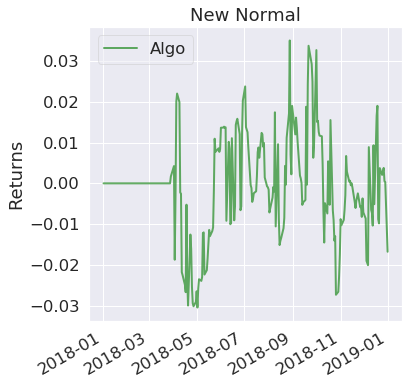

In [5]:
# Run a year at a time, load the price and market cap datasets.
# Load the eigen portfolios generated in the previous year, we will use the same throughout the entire backtesting year
# Potentially, they can be recalculated intra-year. 
# Need to explore if that helps with the performance of the strategy. 

years = [2018]

for yr in years:
    
    # Cerebro configuration
    cerebro = bt.Cerebro(stdstats=True)
    cerebro.broker.setcash(1e6)
    start = datetime.datetime(yr, 1, 1)
    end = datetime.datetime(yr, 12, 31)
    data, mktcap, eigen_portfolios = utils.load_datasets(yr)
    # Determine the stocks to load in the backtesting from the market cap threshold
    mktcap_filtered = utils.filter_by_mktcap(mktcap, mktcap_thresh)
    # Ensure the companies selected exist in the eigen portfolio data
    universe = eigen_portfolios.columns.intersection(mktcap_filtered)
    eigen_portfolios = eigen_portfolios[universe]

    %time cerebro_load_prices(cerebro, universe)

    #load a stock in the universe to read dates ==> determine rebalance dates
    stock = data[data.TICKER == universe[0]]
    bal_dates = stock.iloc[59::60].index
    cerebro.addstrategy(StatArb,params=[eigen_portfolios,bal_dates])
    cerebro.addobserver(bt.observers.Broker)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.Trades)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
    %time results = cerebro.run()
    utils.present_results(cerebro, results)